<a href="https://colab.research.google.com/github/julianmarceloluque/Deep-Learning/blob/main/Labeled%20Faces%20in%20the%20Wild.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico Final Deep Learning - Luque Julian Marcelo
## Consigna:
El participante deberá entrenar dos modelos de redes neuronales para resolver el
problema de clasificación de rostros de Labeled Faces in the Wild (LFW), usando un
subconjunto del dataset homónimo disponible en scikit-learn; este subconjunto está
conformado por los 7 personajes que tienen 70 o más imágenes disponibles dentro del
dataset.

El primer modelo debe ser una red densa y el segundo modelo una red convolucional. Separe el dataset en conjuntos de entrenamiento y prueba utilizando el comando
train_test_split; la fracción de datos de prueba debe estar entre 20% y 30%. Con cada
uno de los modelos, debe obtenerse una precisión (accuracy) de al menos 90% sobre
el conjunto de entrenamiento y al menos 80% sobre el conjunto de prueba.

Además de la precisión total sobre los conjuntos de entrenamiento y prueba, evalúe el desempeño de los modelos utilizando la matriz de confusión sobre el conjunto de prueba. Las etiquetas (labels) de la matriz de confusión deben ser los nombres de los personajes. Comente los resultados obtenidos.

Dentro del archivo TP Final.zip, encontrará una jupyter notebook TP_Final.ipynb con
una visualización simple del conjunto de datos, que sirve como punto de partida.


---



# Importación de librerías

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import MSE
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Parámetros de modelo y entrenamiento


In [ ]:
epochs = 100
batch_size = 20
np.random.seed(14)

# Carga y visualización del dataset

In [ ]:
# Utilizaremos solo imagenes de las 7 personas con mas de 70 imagenes disponibles.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4, color=False, download_if_missing=True)

# Inspeccion de los tamaños
n_samples, h, w = lfw_people.images.shape

# Datos sin divir en subconjuntos
X = lfw_people.images

# Etiquetas y clases
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("h, w: (%d, %d)" % (h, w))
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("target_names: %s" % target_names)

Total dataset size:
h, w: (50, 37)
n_samples: 1288
n_classes: 7
target_names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [ ]:
# Algunas funciones para graficar
def plot_gallery(images, number, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(number):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y, target_names):
    return "%s" % (target_names[y])

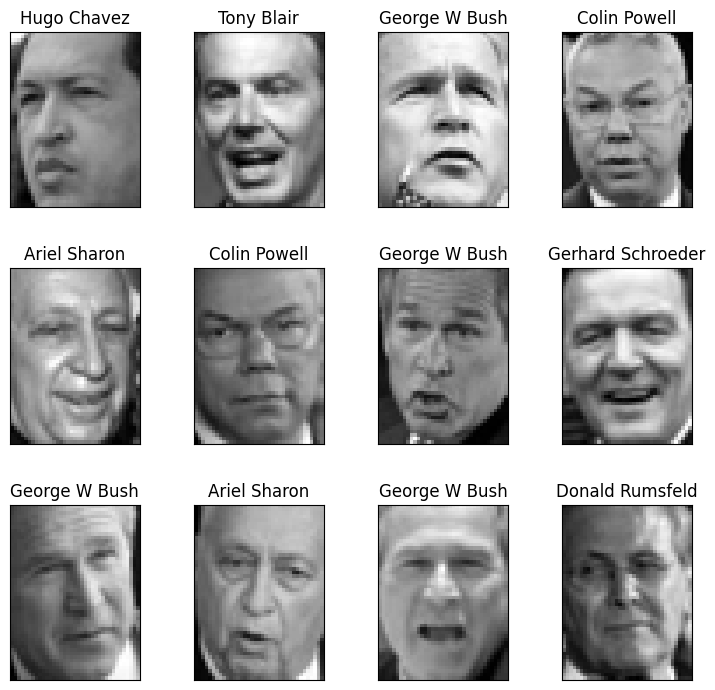

In [ ]:
titles = [title(y[i], target_names) for i in range(20)]
plot_gallery(X, 12 , titles, h, w)



---


# Red Neuronal Densa


---



## Separación de datos




In [ ]:
# División del set de datos
x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,  # 25% de los datos son para Testing
    random_state=42, # para reproducibilidad
    stratify=y
)

print("X: ", X.shape)
print("y: ", y.shape)
print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)

X:  (1288, 50, 37)
y:  (1288,)
Train: (966, 50, 37) (966,)
Test : (322, 50, 37) (322,)


## Preparación de datos - One-hot encoding y Aplanamiento de datos

In [ ]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes) #one-hot encoding

# Aplanamiento de imagenes para la red densa
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)

Train: (966, 1850) (966, 7)
Test : (322, 1850) (322, 7)


## Modelo - Red Densa

In [ ]:
# Model
#---------------------------------------------------------------------#
input_layer = Input(shape=x_train.shape[1:])
dense_1 = Dense(128, activation='relu') (input_layer)
dropout_1 = Dropout(0.4) (dense_1)
dense_2 = Dense(32, activation='relu') (dropout_1)
dropout_2 = Dropout(0.4) (dense_2)
output_layer = Dense(n_classes, activation='softmax') (dense_1)
#---------------------------------------------------------------------#
model_dense = Model(input_layer, output_layer)

In [ ]:
# Model compile
model_dense.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', 'mse'])

model_dense.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1850)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       236,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,831 (929.03 KB)

 Trainable params: 237,831 (929.03 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento de datos

In [ ]:
# En caso de querer usar EarlyStopping descomentar la siguiente línea y utilizarlo de los parámetros de history_dense en 'callbacks'
# callback_dense = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

start_time = time.time()
history_dense = model_dense.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    shuffle=True,
    callbacks=[],
    verbose=1,
)
end_time = time.time()
print(
    "\nElapsed Dense Model training time: {:.5f} seconds".format(end_time - start_time)
)


Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - acc: 0.3628 - loss: 1.9017 - mse: 0.1152 - val_acc: 0.4379 - val_loss: 1.5747 - val_mse: 0.1003
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.4168 - loss: 1.6358 - mse: 0.1049 - val_acc: 0.5155 - val_loss: 1.5194 - val_mse: 0.0941
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.5301 - loss: 1.4208 - mse: 0.0903 - val_acc: 0.5404 - val_loss: 1.3586 - val_mse: 0.0886
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5108 - loss: 1.3467 - mse: 0.0883 - val_acc: 0.4814 - val_loss: 1.4821 - val_mse: 0.0960
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5130 - loss: 1.3485 - mse: 0.0890 - val_acc: 0.4689 - val_loss: 1.4563 - val_mse: 0.0947
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.5394 - loss: 1.2681 - mse: 0.0848 - val_acc: 0.6180 - val_loss: 1.1866 - val_mse: 0.0769
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.6060 - loss: 1.1273 - mse: 0.0760 - val_acc: 

## Visualización

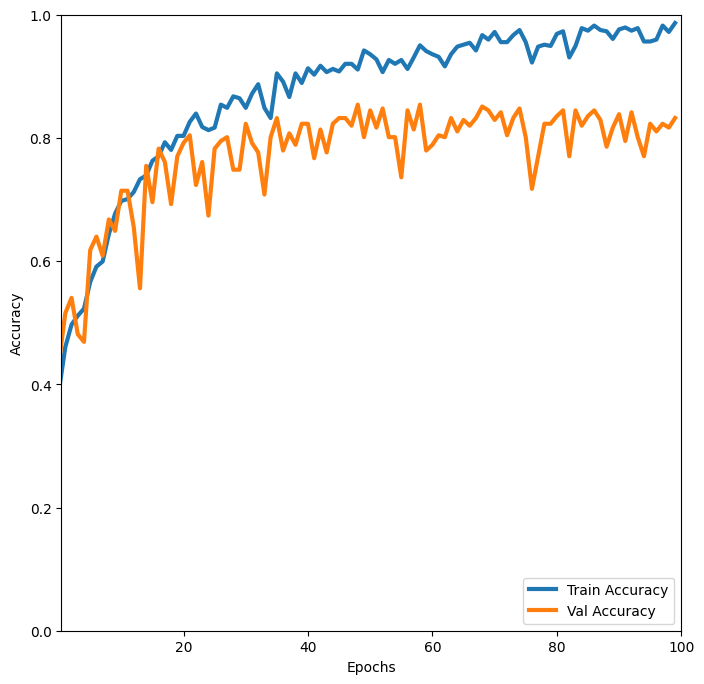

In [ ]:
f = plt.figure(figsize=(8,8))
plt.plot(history_dense.history['acc'], linewidth=3, label='Train Accuracy')
plt.plot(history_dense.history['val_acc'], linewidth=3, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.axis([0.35, epochs, 0, 1])
plt.legend(loc='lower right')
plt.show()

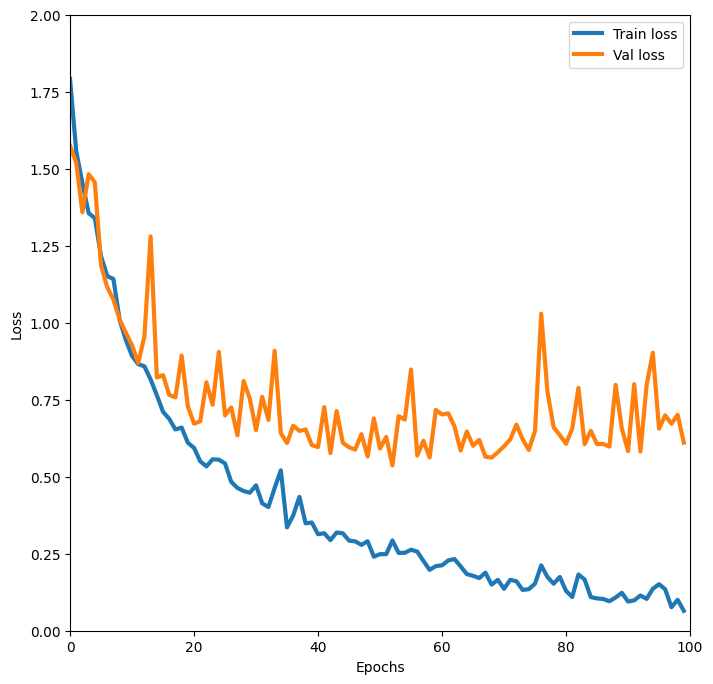

In [ ]:
f = plt.figure(figsize=(8,8))
plt.plot(history_dense.history['loss'], linewidth=3, label='Train loss')
plt.plot(history_dense.history['val_loss'], linewidth=3, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axis([0, epochs, 0, 2])
plt.legend(loc='upper right')

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


Text(50.72222222222221, 0.5, 'True')

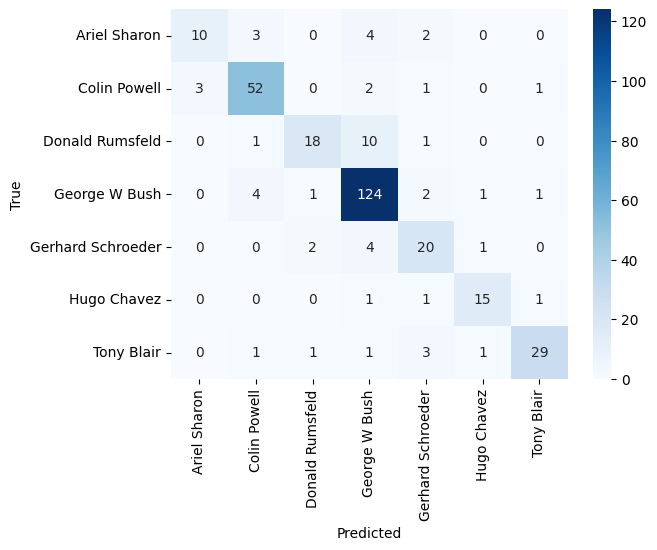

In [ ]:
y_predict_dense = model_dense.predict(x_test)
mat_conf_dense = confusion_matrix(y_test.argmax(axis=1), y_predict_dense.argmax(axis=1))

sns.heatmap(
    mat_conf_dense,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
)

plt.xlabel("Predicted")
plt.ylabel("True")




---


# Red Neuronal Convolucional


---



## Separación de datos




In [ ]:
# División del set de datos
x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,  # 25% de los datos son para Testing
    random_state=42, # para reproducibilidad
    stratify=y
)

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)
print("X: ", X.shape)
print("y: ", y.shape)

Train: (966, 50, 37) (966,)
Test : (322, 50, 37) (322,)
X:  (1288, 50, 37)
y:  (1288,)


## Preparación de datos

In [ ]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes) #one-hot encoding

In [ ]:
x_train = x_train[..., np.newaxis]
x_test  = x_test[..., np.newaxis]

In [ ]:
x_train.shape

(966, 50, 37, 1)

## Modelo - Red Convolucional

In [ ]:
# Model
#---------------------------------------------------------------------#
# 8 - 16 - 32 - 64 -128 - 256 - 512 - 1024
input_layer = Input(shape=x_train.shape[1:])
conv_1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
pool_1 = MaxPooling2D((2, 2))(conv_1)

drop_1 = Dropout(0.25)(pool_1)

conv_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(drop_1)
pool_2 = MaxPooling2D((2, 2))(conv_2)

drop_2 = Dropout(0.25)(pool_2)

flat = Flatten()(drop_2)
dense_1 = Dense(128, activation='relu')(flat)
drop_3 = Dropout(0.25)(dense_1)

output_layer = Dense(n_classes, activation='softmax')(drop_3)
#---------------------------------------------------------------------#
model_conv = Model(input_layer, output_layer)

In [ ]:
# Model compile
model_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', 'mse'])

model_conv.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 37, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 37, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 9, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 9, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       884,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 904,583 (3.45 MB)

 Trainable params: 904,583 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento de datos

In [ ]:
# En caso de querer usar EarlyStopping descomentar la siguiente línea y utilizarlo de los parámetros de history_conv en 'callbacks'
# callback_conv = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

start_time = time.time()
history_conv = model_conv.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    shuffle=True,
    callbacks=[],
    verbose=1,
)
end_time = time.time()
print(
    "\nElapsed Dense Model training time: {:.5f} seconds".format(end_time - start_time)
)


Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - acc: 0.2937 - loss: 1.8289 - mse: 0.1179 - val_acc: 0.4130 - val_loss: 1.7423 - val_mse: 0.1128
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.3867 - loss: 1.7137 - mse: 0.1110 - val_acc: 0.4130 - val_loss: 1.7017 - val_mse: 0.1103
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.4288 - loss: 1.6443 - mse: 0.1070 - val_acc: 0.4130 - val_loss: 1.6291 - val_mse: 0.1057
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.4339 - loss: 1.5869 - mse: 0.1026 - val_acc: 0.5311 - val_loss: 1.3155 - val_mse: 0.0871
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5407 - loss: 1.3217 - mse: 0.0877 - val_acc: 0.6429 - val_loss: 0.9530 - val_mse: 0.0646
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.6350 - loss: 0.9234 - mse: 0.0650 - val_acc: 0.7329 - val_loss: 0.7009 - val_mse: 0.0480
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7617 - loss: 0.6772 - mse: 0.0487 - val_acc:

## Visualización

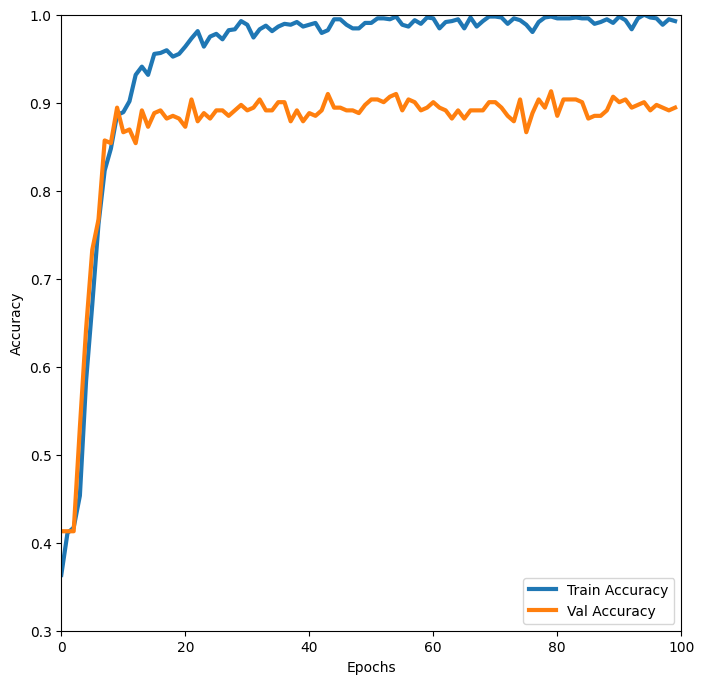

In [ ]:
f = plt.figure(figsize=(8,8))
plt.plot(history_conv.history['acc'], linewidth=3, label='Train Accuracy')
plt.plot(history_conv.history['val_acc'], linewidth=3, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.axis([0, epochs, 0.3, 1])
plt.legend(loc='lower right')
plt.show()

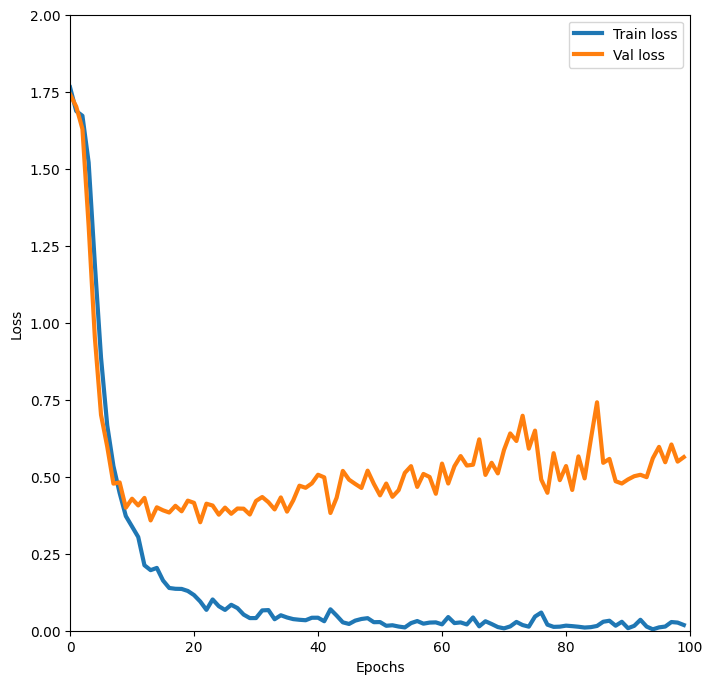

In [ ]:
f = plt.figure(figsize=(8,8))
plt.plot(history_conv.history['loss'], linewidth=3, label='Train loss')
plt.plot(history_conv.history['val_loss'], linewidth=3, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axis([0, epochs, 0, 2])
plt.legend(loc='upper right')

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Text(50.72222222222221, 0.5, 'True')

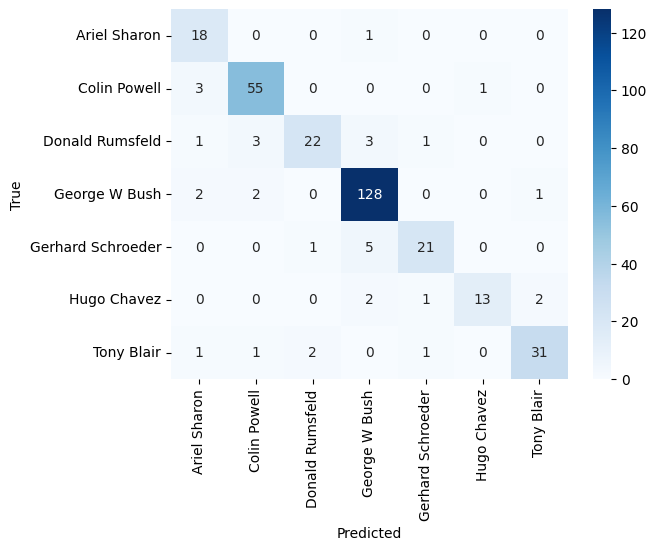

In [ ]:
y_predict_conv = model_conv.predict(x_test)
mat_conf_conv = confusion_matrix(y_test.argmax(axis=1), y_predict_conv.argmax(axis=1))

sns.heatmap(
    mat_conf_conv,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
)

plt.xlabel("Predicted")
plt.ylabel("True")




---


# CNN Data Augmentation


---



Se plantea aplicar la técnica *Data Augmentation* para la red convolucional CNN y contrastar resultados


## Carga y visualización del dataset

In [ ]:
# Utilizaremos solo imagenes de las 7 personas con mas de 70 imagenes disponibles.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4, color=False, download_if_missing=True)

# Inspeccion de los tamaños
n_samples, h, w = lfw_people.images.shape

# Datos sin divir en subconjuntos
X = lfw_people.images

# Etiquetas y clases
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("h, w: (%d, %d)" % (h, w))
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("target_names: %s" % target_names)

Total dataset size:
h, w: (50, 37)
n_samples: 1288
n_classes: 7
target_names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [ ]:
# Algunas funciones para graficar
def plot_gallery(images, number, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(number):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y, target_names):
    return "%s" % (target_names[y])

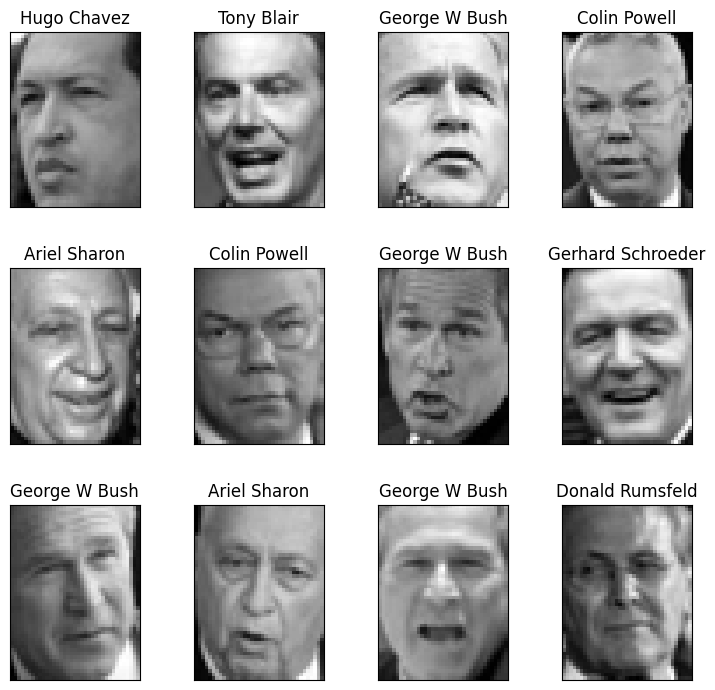

In [ ]:
titles = [title(y[i], target_names) for i in range(20)]
plot_gallery(X, 12 , titles, h, w)

## Separación de datos




In [ ]:
# División del set de datos
x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,  # 25% de los datos son para Testing
    random_state=42, # para reproducibilidad
    stratify=y
)

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)
print("X: ", X.shape)
print("y: ", y.shape)

Train: (966, 50, 37) (966,)
Test : (322, 50, 37) (322,)
X:  (1288, 50, 37)
y:  (1288,)


## Preparación de datos

In [ ]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes) #one-hot encoding

In [ ]:
x_train = x_train[..., np.newaxis]
x_test  = x_test[..., np.newaxis]

In [ ]:
x_train.shape

(966, 50, 37, 1)

## Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,

    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0
)

train_generator = datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size
)

## Modelo - Red Convolucional

In [ ]:
# Model
#---------------------------------------------------------------------#
input_layer = Input(shape=x_train.shape[1:])
conv_1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
pool_1 = MaxPooling2D((2, 2))(conv_1)

drop_1 = Dropout(0.25)(pool_1)

conv_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(drop_1)
pool_2 = MaxPooling2D((2, 2))(conv_2)

drop_2 = Dropout(0.25)(pool_2)

flat = Flatten()(drop_2)
dense_1 = Dense(128, activation='relu')(flat)
drop_3 = Dropout(0.25)(dense_1)

output_layer = Dense(n_classes, activation='softmax')(drop_3)
#---------------------------------------------------------------------#
model_conv_aug = Model(input_layer, output_layer)

In [ ]:
# Model compile
model_conv_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', 'mse'])

model_conv_aug.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50, 37, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 37, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 9, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 9, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       884,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 904,583 (3.45 MB)

 Trainable params: 904,583 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo CNN + Aug

In [ ]:
history_conv_aug = model_conv_aug.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    shuffle=True,
    callbacks=[],
    verbose=1,
)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - acc: 0.3881 - loss: 1.7127 - mse: 0.1101 - val_acc: 0.4130 - val_loss: 1.7708 - val_mse: 0.1144
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.3940 - loss: 1.7229 - mse: 0.1113 - val_acc: 0.4130 - val_loss: 1.7292 - val_mse: 0.1121
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.3949 - loss: 1.7100 - mse: 0.1106 - val_acc: 0.4130 - val_loss: 1.6466 - val_mse: 0.1064
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.4049 - loss: 1.6841 - mse: 0.1084 - val_acc: 0.4286 - val_loss: 1.5543 - val_mse: 0.1001
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.4611 - loss: 1.5491 - mse: 0.1005 - val_acc: 0.5217 - val_loss: 1.4265 - val_mse: 0.0908
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - acc: 0.4992 - loss: 1.4123 - mse: 0.0923 - val_acc: 0.5590 - val_loss: 1.2763 - val_mse: 0.0822
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.5063 - loss: 1.3564 - mse: 0.0898 - val_acc: 0.5870

## Visualización

### Ploteo de Accuaracy
En este caso se podemos observar y contrastar la precisión de los modelos entre la red Densa, la red Convolucional y la red Convolucional más el aumento de datos.

Se puede destacar que en este último gráfico, las curvas de entrenamiento y validación se invierten con respecto a los gráficos anteriores, siendo tal que la curva de validación se posiciona por encima de la de entrenamiento; esto es porque la red obtiene un bajo desempeño a la hora de trabajar con los datos de entrenamiento pero logra un muy buen desempeño a la hora de analizar datos nuevos.

Como plus podemos observar tambien la reducción de la brecha entre estas dos curvas con respecto al modelo de red convolucional sin el aumento de datos.

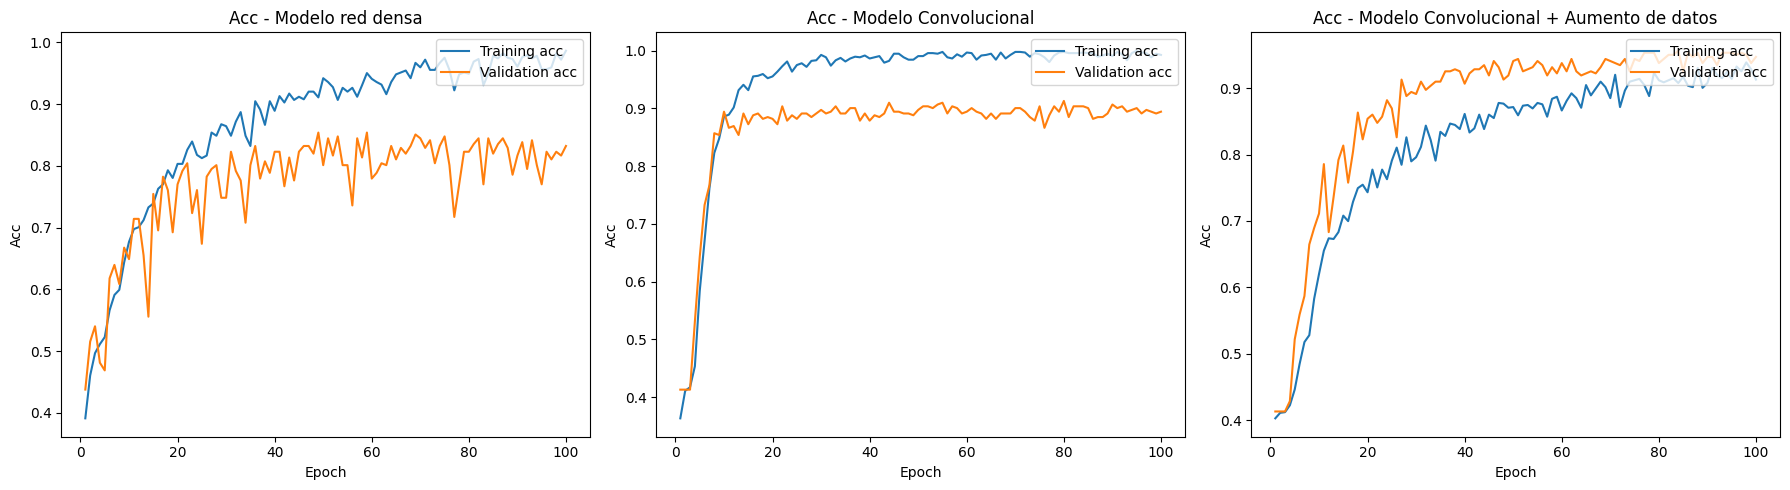

In [ ]:
def show_history_acc_compare(hist_dense, hist_conv, hist_conv_aug):
    plt.figure(figsize=(18, 5))

    # ========= SUBPLOT 1: RED DENSA =========
    plt.subplot(1, 3, 1)
    acc_no = hist_dense.history['acc']
    val_acc_no = hist_dense.history['val_acc']
    epochs = range(1, len(acc_no) + 1)

    plt.plot(epochs, acc_no, '-', label='Training acc')
    plt.plot(epochs, val_acc_no, '-', label='Validation acc')
    plt.title('Acc - Modelo red densa')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend(loc='upper right')

    # ========= SUBPLOT 2: RED CONVOLUCIONAL =========
    plt.subplot(1, 3, 2)
    acc_aug = hist_conv.history['acc']
    val_acc_aug = hist_conv.history['val_acc']
    epochs2 = range(1, len(acc_aug) + 1)

    plt.plot(epochs2, acc_aug, '-', label='Training acc')
    plt.plot(epochs2, val_acc_aug, '-', label='Validation acc')
    plt.title('Acc - Modelo Convolucional')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend(loc='upper right')

    # ========= SUBPLOT 3: RED CONVOLUCIONAL + DATA AUGMENTATION =========
    plt.subplot(1, 3, 3)
    acc_aug = hist_conv_aug.history['acc']
    val_acc_aug = hist_conv_aug.history['val_acc']
    epochs2 = range(1, len(acc_aug) + 1)

    plt.plot(epochs2, acc_aug, '-', label='Training acc')
    plt.plot(epochs2, val_acc_aug, '-', label='Validation acc')
    plt.title('Acc - Modelo Convolucional + Aumento de datos')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Llamada
show_history_acc_compare(history_dense, history_conv, history_conv_aug)


*   El bajo desempeño de entrenamiento en la red convolucional con aumentos de datos se da a raiz de que los datos se encuentran distorcionados, lo cual causa imágenes más difíciles de reconocer.
*   En cambio, el set de validación al no estar distorcionado proporciona imágenes mas claras y fáciles de reconocer y es por eso que posee una precisión mayor.



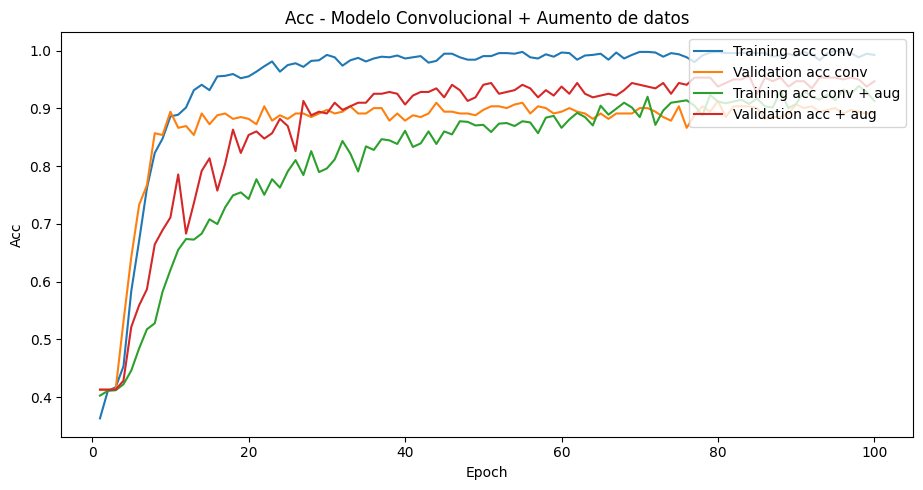

In [ ]:
def show_history_acc_compare(hist_conv, hist_conv_aug):
    plt.figure(figsize=(18, 5))

    # ========= SUBPLOT 1: DATOS ENTRENAMIENTO =========
    plt.subplot(1, 2, 1)
    acc_aug = hist_conv.history['acc']
    val_acc_aug = hist_conv.history['val_acc']
    epochs2 = range(1, len(acc_aug) + 1)

    plt.plot(epochs2, acc_aug, '-', label='Training acc conv')
    plt.plot(epochs2, val_acc_aug, '-', label='Validation acc conv')
    plt.title('Acc - Modelo Convolucional')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend(loc='upper right')

    # ========= SUBPLOT 2: RED CONVOLUCIONAL + DATA AUGMENTATION =========
    plt.subplot(1, 2, 1)
    acc_aug = hist_conv_aug.history['acc']
    val_acc_aug = hist_conv_aug.history['val_acc']
    epochs2 = range(1, len(acc_aug) + 1)

    plt.plot(epochs2, acc_aug, '-', label='Training acc conv + aug')
    plt.plot(epochs2, val_acc_aug, '-', label='Validation acc + aug')
    plt.title('Acc - Modelo Convolucional + Aumento de datos')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

print(history_conv)
show_history_acc_compare(history_conv, history_conv_aug)

### Ploteo de Loss
En este caso se podemos observar y contrastar la pérdida de los modelos entre la red Densa, la red Convolucional y la red Convolucional más el aumento de datos.

Se puede destacar que en este último gráfico, las curvas de entrenamiento y validación se invierten con respecto a los gráficos anteriores, siendo tal que la curva de validación se posiciona por debajo de la de entrenamiento; esto es porque la red obtiene una mayor pérdida a la hora de trabajar con los datos de entrenamiento pero logra una pérdida mucho menor a la hora de analizar datos nuevos.

El análisis del '¿por qué?' sucesde esto es similar a lo explicado al analizar la precisión; y es porque los datos de entrenamiento se encuentran 'sucios' al estar distorcionados por el aumento de datos proporcionando así un incremento en la pérdida. En contraste esto genera una menor pérdida al analizar datos nuevos, ya que los datos de validación se encuentran 'limpios'

Como plus podemos observar también la reducción de la brecha entre estas dos curvas con respecto al modelo de red convolucional sin el aumento de datos.

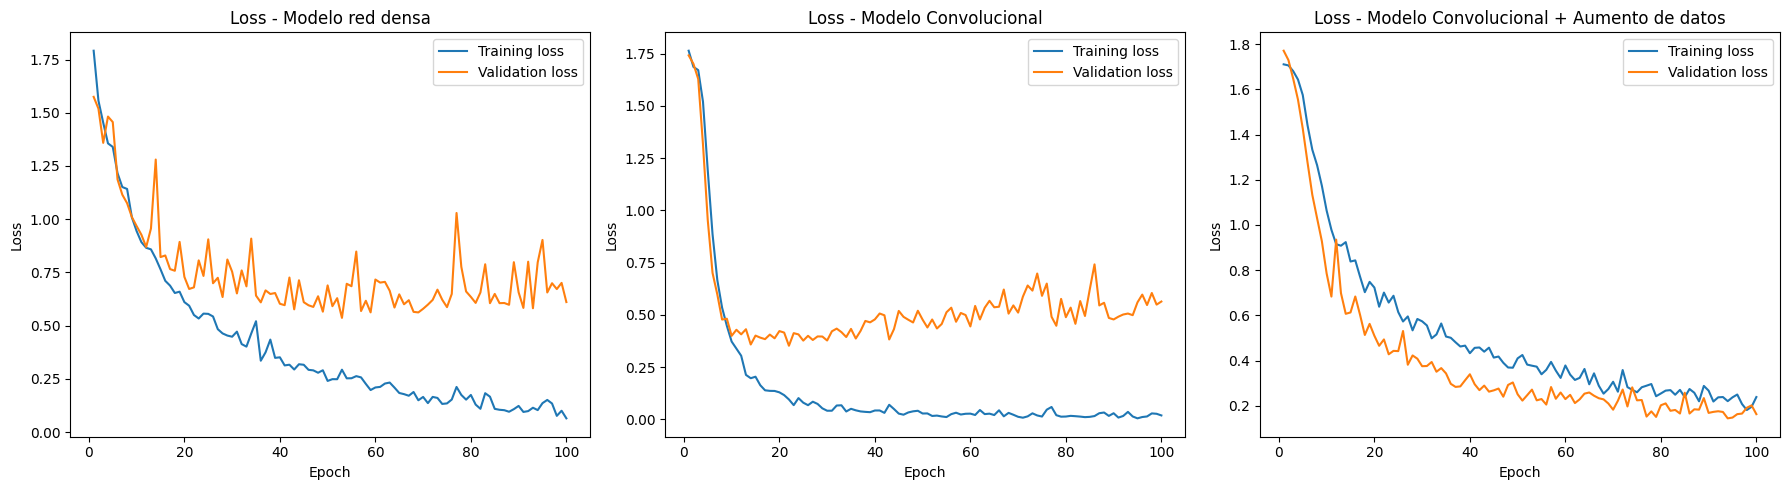

In [ ]:
def show_history_acc_compare(hist_dense, hist_conv, hist_conv_aug):
    plt.figure(figsize=(18, 5))

    # ========= SUBPLOT 1: RED DENSA =========
    plt.subplot(1, 3, 1)
    loss_no = hist_dense.history['loss']
    val_loss_no = hist_dense.history['val_loss']
    epochs = range(1, len(loss_no) + 1)

    plt.plot(epochs, loss_no, '-', label='Training loss')
    plt.plot(epochs, val_loss_no, '-', label='Validation loss')
    plt.title('Loss - Modelo red densa')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # ========= SUBPLOT 2: RED CONVOLUCIONAL =========
    plt.subplot(1, 3, 2)
    loss_aug = hist_conv.history['loss']
    val_loss_aug = hist_conv.history['val_loss']
    epochs2 = range(1, len(loss_aug) + 1)

    plt.plot(epochs2, loss_aug, '-', label='Training loss')
    plt.plot(epochs2, val_loss_aug, '-', label='Validation loss')
    plt.title('Loss - Modelo Convolucional')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # ========= SUBPLOT 3: RED CONVOLUCIONAL + DATA AUGMENTATION =========
    plt.subplot(1, 3, 3)
    loss_aug = hist_conv_aug.history['loss']
    val_loss_aug = hist_conv_aug.history['val_loss']
    epochs2 = range(1, len(loss_aug) + 1)

    plt.plot(epochs2, loss_aug, '-', label='Training loss')
    plt.plot(epochs2, val_loss_aug, '-', label='Validation loss')
    plt.title('Loss - Modelo Convolucional + Aumento de datos')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Llamada
show_history_acc_compare(history_dense, history_conv, history_conv_aug)

### Matriz de confusión para red convolucional con aumento de datos

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


Text(50.72222222222221, 0.5, 'True')

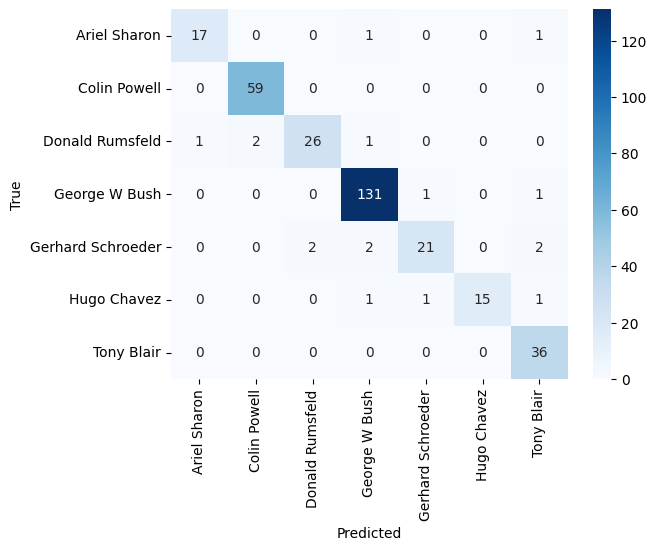

In [ ]:
y_predict_conv_aug = model_conv_aug.predict(x_test)
mat_conf_conv_aug = confusion_matrix(y_test.argmax(axis=1), y_predict_conv_aug.argmax(axis=1))

sns.heatmap(
    mat_conf_conv_aug,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
)

plt.xlabel("Predicted")
plt.ylabel("True")
